# 1. Data Preprocessing

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample data (English to Kanembu)
data = [
    ("Abakar is looking for banana", "Abakar banana mâi"),
    ("He is looking for onion", "Ti basal mâi"),
    ("Abakar sells pots", "Abakar tasa cilâdi"),
    ("Fatime goes to the market", "Fatime kasuw-ro tîdi"),
    ("Abakar goes to the market", "Abakar kasuw-ro tîdi"),
    ("Dog goes to the market", "Kiri kasuw-ro tîdi"),
    ("Did Abakar read papers?", "Abakar-i kakadu kərâi a?"),
    ("Yes, he read", "Yəi, Abakar-i kərâi."),
    ("Did Fatime go to the market?", "Fatime kasuw-ro tîdi a?"),
    ("Yes, she went to the market.", "Yəi, kasuw-ro tîdi."),
    ("Did Fatime look for oil?", "Fatime-i kəndaw mâi a?"),
    ("Yes, she looked for oil.", "Yəi, kəndaw mâi."),
    ("Did the vendor sell oil?", "Kasuwma-i kəndaw cilâdi a?"),
    ("Yes, he sold oil.", "Yəi, kəndaw cilâdi.")
]

# Split data into English and Kanembu
english_sentences = [pair[0] for pair in data]
kanembu_sentences = [pair[1] for pair in data]

# Add special tokens to Kanembu sentences (start and end tokens)
kanembu_sentences = ["start_token " + sentence + " end_token" for sentence in kanembu_sentences]

# Tokenizer for English
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_sentences)
english_sequences = english_tokenizer.texts_to_sequences(english_sentences)

# Tokenizer for Kanembu
kanembu_tokenizer = Tokenizer()
kanembu_tokenizer.fit_on_texts(kanembu_sentences)
kanembu_sequences = kanembu_tokenizer.texts_to_sequences(kanembu_sentences)

# Pad sequences to ensure equal length
max_encoder_seq_length = max([len(seq) for seq in english_sequences])
max_decoder_seq_length = max([len(seq) for seq in kanembu_sequences])

english_sequences_padded = pad_sequences(english_sequences, maxlen=max_encoder_seq_length, padding='post')
kanembu_sequences_padded = pad_sequences(kanembu_sequences, maxlen=max_decoder_seq_length, padding='post')

# Vocabulary sizes (accounting for start_token and end_token)
english_vocab_size = len(english_tokenizer.word_index) + 1
kanembu_vocab_size = len(kanembu_tokenizer.word_index) + 1

# Prepare target data for training (shift decoder output by one time step)
decoder_input_data = kanembu_sequences_padded[:, :-1]
decoder_target_data = kanembu_sequences_padded[:, 1:]

# Convert target data to one-hot encoding
decoder_target_data = tf.keras.utils.to_categorical(decoder_target_data, kanembu_vocab_size)

# Output the shapes of the processed data to verify correctness
print(f"English sequences padded shape: {english_sequences_padded.shape}")
print(f"Kanembu sequences padded shape: {kanembu_sequences_padded.shape}")
print(f"Decoder input data shape: {decoder_input_data.shape}")
print(f"Decoder target data shape: {decoder_target_data.shape}")
print(f"English vocab size: {english_vocab_size}")
print(f"Kanembu vocab size: {kanembu_vocab_size}")


English sequences padded shape: (14, 6)
Kanembu sequences padded shape: (14, 9)
Decoder input data shape: (14, 8)
Decoder target data shape: (14, 8, 23)
English vocab size: 29
Kanembu vocab size: 23


#2. Model Building (Encoder-Decoder with RNN)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Model parameters
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(english_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(kanembu_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(kanembu_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn encoder_input_data & decoder_input_data into decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 256)      │          7,424 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │          5,888 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 512), (None,   │      1,574,912 │ embedding_2[0][0]      │
│                           │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 512),    │      1,574,912 │ embedding_3[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm_2[0][1],          │
│                           │ 512)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 23)       │         11,799 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,174,935 (12.11 MB)

 Trainable params: 3,174,935 (12.11 MB)

 Non-trainable params: 0 (0.00 B)

#3. Training the Model

In [8]:
# Training data
encoder_input_data = english_sequences_padded
decoder_input_data = kanembu_sequences_padded[:, :-1]

# Train the model
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=64, epochs=100, validation_split=0.2)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0568 - loss: 3.1352 - val_accuracy: 0.4167 - val_loss: 3.0964
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3636 - loss: 3.0909 - val_accuracy: 0.4167 - val_loss: 3.0599
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3750 - loss: 3.0482 - val_accuracy: 0.4167 - val_loss: 3.0112
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3750 - loss: 2.9920 - val_accuracy: 0.4167 - val_loss: 2.9302
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3750 - loss: 2.9002 - val_accuracy: 0.3750 - val_loss: 2.7650
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2955 - loss: 2.7182 - val_accuracy: 0.2500 - val_loss: 2.5224
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2500 - loss: 2.4788 - val_accuracy: 0.2917 - val_loss: 2.5028
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2500 - loss: 2.4141 - val_accuracy: 0.2500 - val_loss

In [18]:
model.evaluate([encoder_input_data, decoder_input_data], decoder_target_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9196 - loss: 0.6629


[0.6629391312599182, 0.9196428656578064]

#4.Plotting the Training History

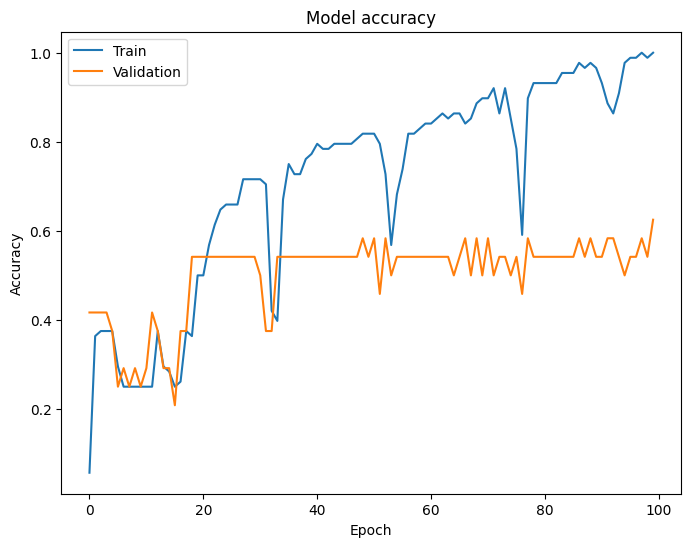

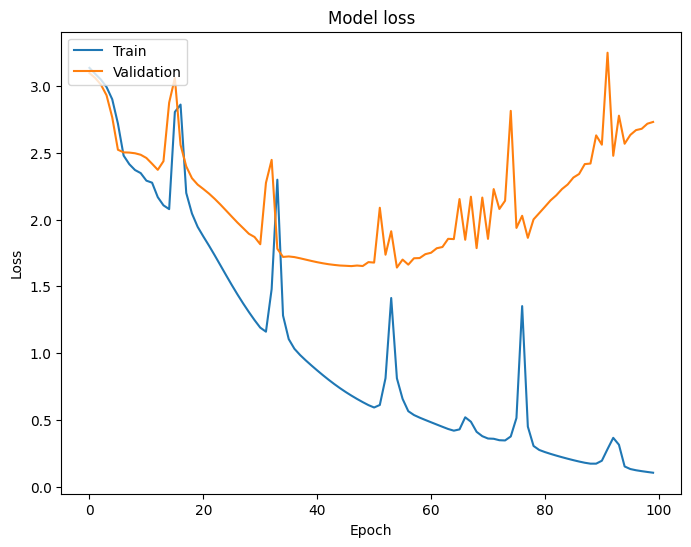

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#5. Inference (Translation)

In [12]:
# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

def translate_sentence(input_sentence):
    input_seq = english_tokenizer.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_seq_length, padding='post')

    # Encode input
    states_value = encoder_model.predict(input_seq)

    # Generate translation
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = kanembu_tokenizer.word_index['start']  # Start token

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = kanembu_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == 'end' or len(decoded_sentence.split()) > max_decoder_seq_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target sequence (for the next time step) and states
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()


In [13]:
print(kanembu_tokenizer.word_index)  # This should now contain 'start_token' and 'end_token'


{'token': 1, 'start': 2, 'end': 3, 'abakar': 4, 'kasuw': 5, 'ro': 6, 'tîdi': 7, 'mâi': 8, 'i': 9, 'a': 10, 'yəi': 11, 'kəndaw': 12, 'cilâdi': 13, 'fatime': 14, 'kərâi': 15, 'banana': 16, 'ti': 17, 'basal': 18, 'tasa': 19, 'kiri': 20, 'kakadu': 21, 'kasuwma': 22}


#6. Evaluation (BLEU Score)

In [14]:
from nltk.translate.bleu_score import sentence_bleu

# Reference and candidate translations
reference = ['Abakar banana mâi'.split()]
candidate = translate_sentence('Abakar is looking for banana').split()

# Compute BLEU score
from nltk.translate.bleu_score import sentence_bleu
bleu_score = sentence_bleu(reference, candidate)
print(f"BLEU Score: {bleu_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
BLEU Score: 9.53091075863908e-155


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


#7. Translate Multiple Sentences and Compare BLEU Scores

In [17]:
# Define some test sentences for translation
test_sentences = [
    "Abakar is looking for banana",
    "Did Fatime go to the market?",
    "Abakar sells pots",
    "Fatime goes to the market",
    'Ali is looking for pots'
]

# Define the reference translations in Kanembu
reference_translations = [
    "Abakar banana mâi",
    "Fatime kasuw-ro tîdi a?",
    "Abakar tasa cilâdi",
    "Fatime kasuw-ro tîdi",
    'Ali tasa mâi'
]

# Loop through the test cases and calculate BLEU scores
for i, sentence in enumerate(test_sentences):
    predicted_translation = translate_sentence(sentence)
    reference = [reference_translations[i].split()]
    candidate = predicted_translation.split()
    bleu_score = sentence_bleu(reference, candidate)
    print(f"English Sentence: {sentence}")
    print(f"Predicted Translation: {predicted_translation}")
    print(f"Reference Translation: {' '.join(reference[0])}")
    print(f"BLEU Score: {bleu_score}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English Sentence: Abakar is looking for banana
Predicted Translation: token abakar banana mâi
Reference Translation: Abakar banana mâi
BLEU Score: 9.53091075863908e-155

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
English Sentence: Did Fatime go to the market?
Predicted Translation: token fatime kasuw ro tîdi a
Reference Translation: Fatime kasuw-ro tîdi a?
BLEU Score: 1.1640469867513693e-231

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1

#8. Considerations for Improvements